<a href="https://colab.research.google.com/github/alexlin51/GANs-Album-Covers/blob/main/Album_Cover_Fun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grabbing Data from Kaggle


In [ ]:
! pip install -q kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alexlinn51","key":"a9dc11605c770f8c489e6021d2df21b9"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d greg115/album-covers-images

100% 3.03G/3.05G [00:49<00:00, 100MB/s]
100% 3.05G/3.05G [00:49<00:00, 65.7MB/s]


In [ ]:
! mkdir train
! unzip album-covers-images.zip -d train

Streaming output truncated to the last 5000 lines.
  inflating: train/album_covers_512/77259.jpg  
  inflating: train/album_covers_512/7726.jpg  
  inflating: train/album_covers_512/77260.jpg  
  inflating: train/album_covers_512/77261.jpg  
  inflating: train/album_covers_512/77262.jpg  
  inflating: train/album_covers_512/77263.jpg  
  inflating: train/album_covers_512/77264.jpg  
  inflating: train/album_covers_512/77265.jpg  
  inflating: train/album_covers_512/77266.jpg  
  inflating: train/album_covers_512/77267.jpg  
  inflating: train/album_covers_512/77268.jpg  
  inflating: train/album_covers_512/77269.jpg  
  inflating: train/album_covers_512/7727.jpg  
  inflating: train/album_covers_512/77270.jpg  
  inflating: train/album_covers_512/77271.jpg  
  inflating: train/album_covers_512/77272.jpg  
  inflating: train/album_covers_512/77273.jpg  
  inflating: train/album_covers_512/77274.jpg  
  inflating: train/album_covers_512/77275.jpg  
  inflating: train/album_covers_512/772

# Setting up Env  

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable

if torch.cuda.is_available():
    device = torch.device("cuda:0")  
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [ ]:
DIR = os.getcwd()
print(DIR)
REBUILD_DATA = True
try: 
  if os.path.exists(f"{DIR}/training_data.npy"):
    REBUILD_DATA = False  
except Exception as e:
  pass

print(REBUILD_DATA)

/content
True


In [ ]:
BATCH_SIZE = 64
EPOCHS = 50
PIXELS = 128

# Creating DataLoader

In [ ]:
class MusicAlbums():
    training_data = []
    total = 0

    def make_training_data(self):
      for f in tqdm(os.listdir(f"{DIR}/train/album_covers_512")):
        if self.total > 60000:
          break
        try:
          img = cv2.imread(f"{DIR}/train/album_covers_512/{f}")
          img = cv2.resize(img, (PIXELS, PIXELS))
          self.training_data.append([np.array(img)]) 
          self.total += 1         
        except Exception as e:
          pass
                
      np.random.shuffle(self.training_data)
      np.save("training_data.npy", self.training_data) 
      print("Total:", self.total)
  

if REBUILD_DATA:
    ma = MusicAlbums()
    ma.make_training_data()

Total: 60001


60001


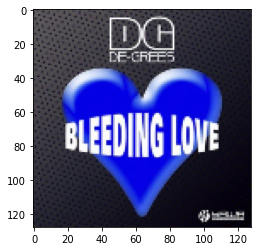

In [ ]:
training_data = np.load("training_data.npy", allow_pickle=True)
print(len(training_data))
plt.imshow(training_data[5][0])
plt.show()

In [ ]:
trainingLoader = torch.utils.data.DataLoader(training_data, batch_size=BATCH_SIZE,
                                            shuffle=True)

# Creating Generator and Discriminator Models

In [ ]:
nc = 3 # Number of color channels
d_dim = 50 # Length of latent Vector (nz)

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.main = nn.Sequential(
      nn.ConvTranspose2d(d_dim, PIXELS * 8, 4, 2, 0, bias=False),
      nn.BatchNorm2d(PIXELS * 8),
      nn.ReLU(True),
      nn.ConvTranspose2d(PIXELS * 8, PIXELS * 4, 4, 2, 1, bias=False),
      nn.BatchNorm2d(PIXELS * 4),
      nn.ReLU(True),
      nn.ConvTranspose2d(PIXELS * 4, PIXELS * 2, 4, 2, 1, bias=False),
      nn.BatchNorm2d(PIXELS * 2),
      nn.ReLU(True),
      nn.ConvTranspose2d(PIXELS * 2, PIXELS, 4, 2, 1, bias=False),
      nn.BatchNorm2d(PIXELS),
      nn.ReLU(True),
      nn.ConvTranspose2d(PIXELS, PIXELS, 4, 2, 1, bias=False),
      nn.BatchNorm2d(PIXELS),
      nn.ReLU(True),
      nn.ConvTranspose2d(PIXELS, nc, 4, 2, 1, bias=False),
      nn.Tanh()
  )
    
  def forward(self, x): 
    return self.main(x)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, PIXELS, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(PIXELS, PIXELS * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(PIXELS * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(PIXELS * 2, PIXELS * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(PIXELS * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(PIXELS * 4, PIXELS * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(PIXELS * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(PIXELS * 8, PIXELS * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(PIXELS * 16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(PIXELS * 16, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
       return self.main(x)

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath, map_location=torch.device('cpu'))
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    model.eval()
    
    return model

D = load_checkpoint('./checkpointD.pth').to(device)
G = load_checkpoint('./checkpointG.pth').to(device)

In [ ]:
G = Generator().to(device)
D = Discriminator().to(device)

In [ ]:
print(G)
print(D)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(50, 1024, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchN

In [ ]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

# Training Our GANs

In [ ]:
def D_train(x):
  x = torch.squeeze(x)
  D.zero_grad()

  # Creating inputs of real data
  x = x.float()
  realX, realY = x.view(x.size(0),3, 128, 128).to(device), torch.ones(x.size(0), 1).to(device)
  D_real_output = D(realX).view(x.size(0), 1)
  D_real_loss = criterion(D_real_output, realY)
  
  # Creating inputs of generated data
  z = torch.randn(x.size(0),d_dim,1,1).to(device)
  fakeX, fakeY = G(z), torch.zeros(x.size(0), 1).to(device)
  D_fake_output = D(fakeX)
  D_fake_output = D_fake_output.view(x.size(0), 1)
  D_fake_loss = criterion(D_fake_output, fakeY)
  
  # Take the average
  D_loss = Variable((D_fake_loss + D_real_loss)/2, requires_grad=True)
  D_loss.backward()
  D_optimizer.step()     

  # print("D ", D_loss.item())
  return D_loss.item(), x.size(0)

In [ ]:
def G_train(size):
  G.zero_grad()

  # Is this consider a random distribution?
  z = torch.randn(size,d_dim,1,1).to(device)
  # We want the Discriminator to think this is all real data
  y = torch.ones(size,1).to(device)

  G_output = G(z)
  D_output = D(G_output)
  D_output = D_output.view(size,1)
  G_loss = Variable(criterion(D_output, y), requires_grad=True)

  G_loss.backward()
  G_optimizer.step()
  
  # print("G ", G_loss.item())
  return G_loss.item()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


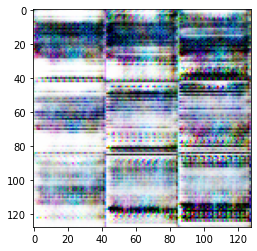

In [ ]:
def view_G():
  with torch.no_grad():
    test_z = torch.randn(BATCH_SIZE,d_dim,1,1).to(device)
    generate = G(test_z)

    img = generate.view(generate.size(0), PIXELS, PIXELS, 3).cpu()
    # plt.imshow(img[0].cpu().numpy().squeeze());
    # plt.imshow(np.uint8(img[0].cpu().numpy()))
    # plt.imshow(img[0])
    return img[0]

plt.imshow(view_G())

In [ ]:
def save():
  checkpointG = {'model': Generator(),
              'state_dict': G.state_dict(),
              'optimizer' : G_optimizer.state_dict()}
  torch.save(checkpointG, 'checkpointG.pth')
  checkpointD = {'model': Discriminator(),
              'state_dict': D.state_dict(),
              'optimizer' : D_optimizer.state_dict()}
  torch.save(checkpointD, 'checkpointD.pth')

In [ ]:
generated = []

for epoch in tqdm(range(1, EPOCHS + 1), desc="Epochs Progress"):
  D_losses, G_losses = [], []
  for batch_idx, x in tqdm(enumerate(trainingLoader), desc="Batch Progress"):
    val, size = D_train(x)
    D_losses.append(val)
    G_losses.append(G_train(size))
  
  d_mean = torch.mean(torch.FloatTensor(D_losses))
  g_mean = torch.mean(torch.FloatTensor(G_losses))
  print(f"Epoch: {epoch} | D_loss: {d_mean} | G_loss: {g_mean}")
  generated.append(view_G())
  save() 


Epoch: 1 | D_loss: 3.257979154586792 | G_loss: 0.0016135458135977387



Epoch: 2 | D_loss: 3.2582221031188965 | G_loss: 0.0016134969191625714



Epoch: 3 | D_loss: 3.2581207752227783 | G_loss: 0.0016134377801790833



Epoch: 4 | D_loss: 3.2582204341888428 | G_loss: 0.0016126091359183192



Epoch: 5 | D_loss: 3.258246660232544 | G_loss: 0.0016133241588249803



Epoch: 6 | D_loss: 3.2584452629089355 | G_loss: 0.00161272706463933



Epoch: 7 | D_loss: 3.2581934928894043 | G_loss: 0.0016133538447320461



Epoch: 8 | D_loss: 3.258090019226074 | G_loss: 0.0016134607139974833



Epoch: 9 | D_loss: 3.258026361465454 | G_loss: 0.0016139348736032844



Epoch: 10 | D_loss: 3.258180856704712 | G_loss: 0.001613395637832582



Epoch: 11 | D_loss: 3.2582807540893555 | G_loss: 0.001613793894648552



Epoch: 12 | D_loss: 3.2581558227539062 | G_loss: 0.0016131200827658176



Epoch: 13 | D_loss: 3.2580678462982178 | G_loss: 0.0016135034384205937



Epoch: 14 | D_loss: 3.2582757472991943 | G_loss: 0.0016141195083037019



Epoch: 15 | D_loss: 3.257990837097168 | G_loss: 0.0016139409272000194



Epoch: 16 | D_loss: 3.258049964904785 | G_loss: 0.0016133500030264258



Epoch: 17 | D_loss: 3.2584893703460693 | G_loss: 0.0016135215992107987



Epoch: 18 | D_loss: 3.2581324577331543 | G_loss: 0.0016131032025441527



Epoch: 19 | D_loss: 3.2581357955932617 | G_loss: 0.0016134943580254912



Epoch: 20 | D_loss: 3.258056879043579 | G_loss: 0.0016132380114868283



Epoch: 21 | D_loss: 3.2582290172576904 | G_loss: 0.001613483065739274



Epoch: 22 | D_loss: 3.2579119205474854 | G_loss: 0.0016135963378474116



Epoch: 23 | D_loss: 3.2583296298980713 | G_loss: 0.001613736036233604



Epoch: 24 | D_loss: 3.2584784030914307 | G_loss: 0.001613837550394237



Epoch: 25 | D_loss: 3.2580671310424805 | G_loss: 0.0016126158880069852



Epoch: 26 | D_loss: 3.25819730758667 | G_loss: 0.0016134269535541534



Epoch: 27 | D_loss: 3.2581381797790527 | G_loss: 0.0016141661908477545



Epoch: 28 | D_loss: 3.258045196533203 | G_loss: 0.0016132829478010535



Epoch: 29 | D_loss: 3.2579591274261475 | G_loss: 0.0016136138001456857



Epoch: 30 | D_loss: 3.2580149173736572 | G_loss: 0.0016136444173753262



Epoch: 31 | D_loss: 3.2580602169036865 | G_loss: 0.0016132293967530131



Epoch: 32 | D_loss: 3.258263111114502 | G_loss: 0.0016137128695845604



Epoch: 33 | D_loss: 3.2580366134643555 | G_loss: 0.0016132694436237216



Epoch: 34 | D_loss: 3.2582216262817383 | G_loss: 0.00161315081641078



Epoch: 35 | D_loss: 3.258256196975708 | G_loss: 0.001613212050870061



Epoch: 36 | D_loss: 3.258151054382324 | G_loss: 0.0016138774808496237



Epoch: 37 | D_loss: 3.2580370903015137 | G_loss: 0.0016132534947246313



Epoch: 38 | D_loss: 3.258183717727661 | G_loss: 0.0016130262520164251



Epoch: 39 | D_loss: 3.258253812789917 | G_loss: 0.00161347771063447



Epoch: 40 | D_loss: 3.258165121078491 | G_loss: 0.001612975145690143



Epoch: 41 | D_loss: 3.258221387863159 | G_loss: 0.0016130346339195967



Epoch: 42 | D_loss: 3.2582099437713623 | G_loss: 0.0016136475605890155



Epoch: 43 | D_loss: 3.2583374977111816 | G_loss: 0.0016137436032295227



Epoch: 44 | D_loss: 3.2580409049987793 | G_loss: 0.0016132742166519165



Epoch: 45 | D_loss: 3.25822114944458 | G_loss: 0.0016133568715304136



Epoch: 46 | D_loss: 3.2582266330718994 | G_loss: 0.0016132922610267997



Epoch: 47 | D_loss: 3.2582762241363525 | G_loss: 0.0016137855127453804



Epoch: 48 | D_loss: 3.258058786392212 | G_loss: 0.0016129654832184315



Epoch: 49 | D_loss: 3.25816011428833 | G_loss: 0.0016129101859405637



Epoch: 50 | D_loss: 3.258188486099243 | G_loss: 0.0016132823657244444



# Displaying Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

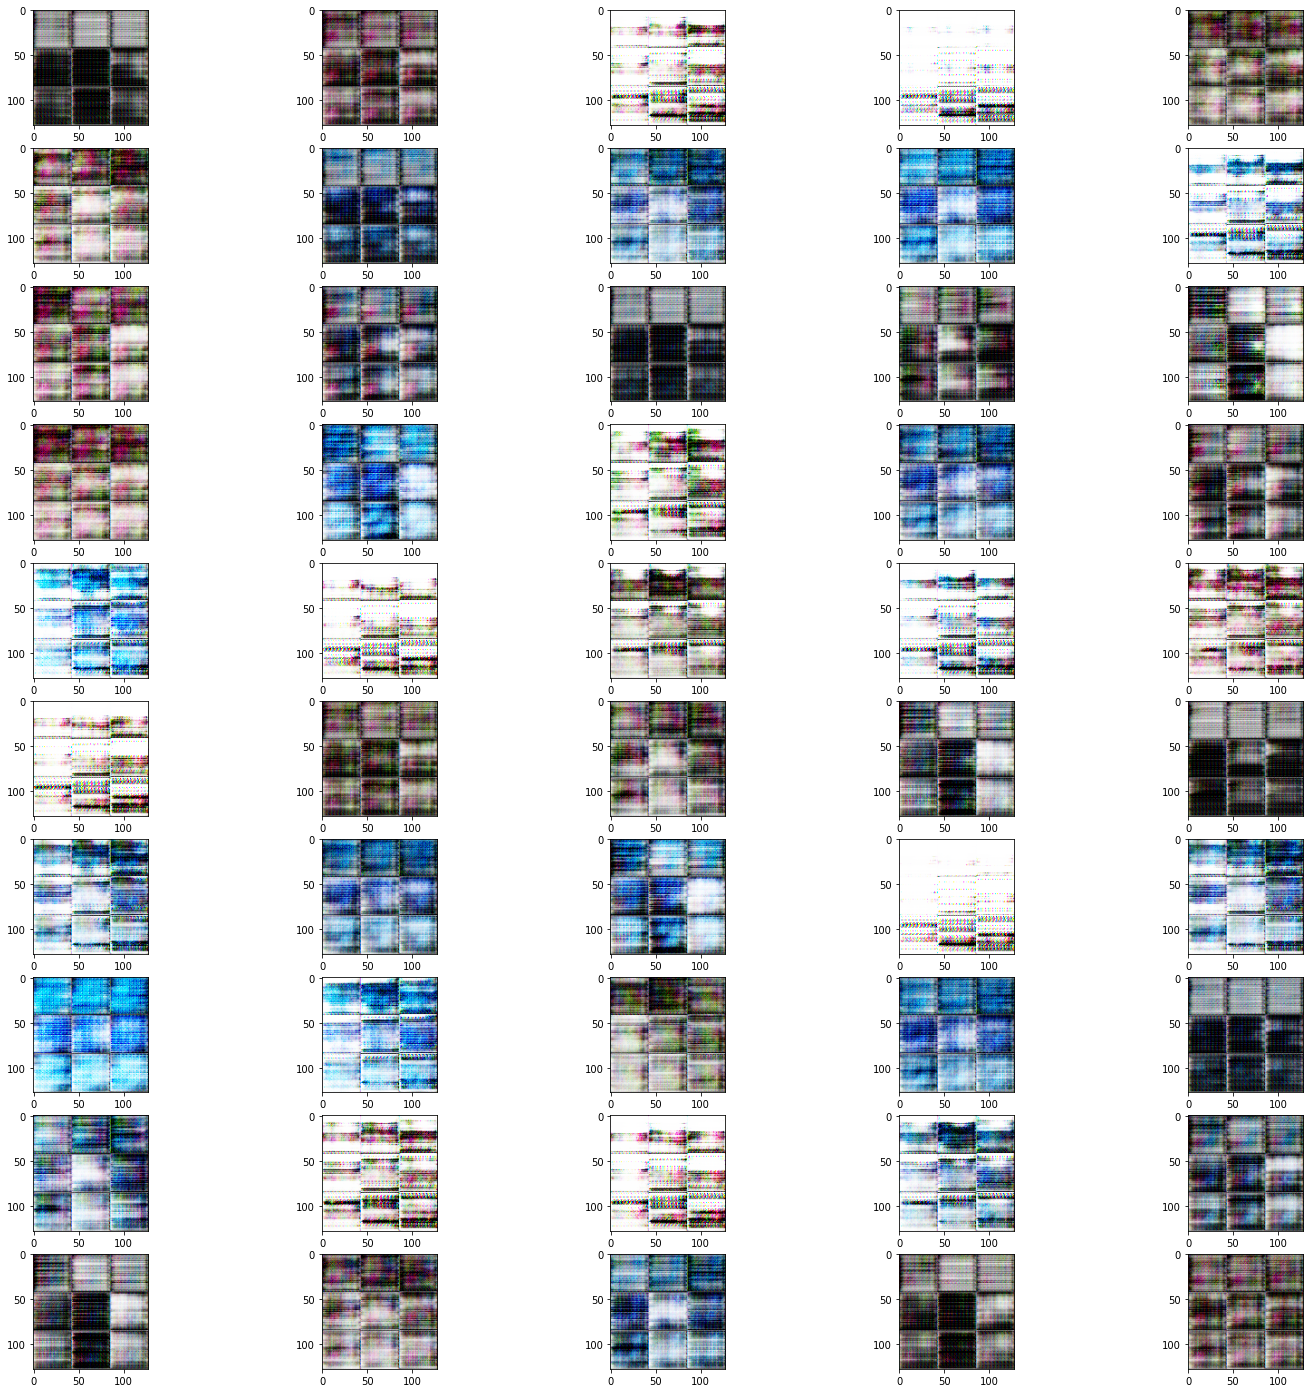

In [ ]:
fig=plt.figure(figsize=(25, 25))    
columns = 5  
rows = 10
for i in tqdm(range(1, columns*rows +1), desc="Drawing Generated Images"):
    fig.add_subplot(rows, columns, i)
    plt.imshow(generated[i-1].cpu())  
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


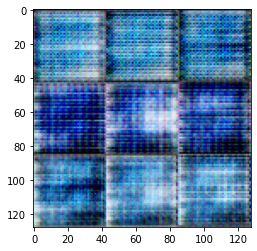

In [ ]:
plt.imshow(view_G())